In [1]:
# Important Points :

import cv2
img=cv2.imread('E:/Other abbas/fa.jpg')
cv2.imshow("image",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

###

In [1]:
# imports:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense,Flatten,Reshape,Activation,BatchNormalization,Conv2D,  Conv2DTranspose  # dis convolution
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

In [2]:
# Make Def:

def make_genrator_model(dim):
    model = Sequential()                         # make model
    model.add(Dense(256*7*7,input_dim=dim))
    model.add(Reshape((7,7,256)))

    # input : (256,7,7)
    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    # output : (128,14,14)
    ###
    model.add(Conv2DTranspose(64,kernel_size=3,strides=1,padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    # output : (64,14,14)
    ###
    model.add(Conv2DTranspose(1,kernel_size=3,strides=2,padding="same"))
    # output : (1,28,28)
    ###
    model.add(Activation("tanh"))
    return model

###

def make_dis_model(shape): 
    model = Sequential()

    # input : (1,28,28)
    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=shape,padding="same"))
    model.add(LeakyReLU(alpha=0.01))
    # output : (32,14,14)
    ###
    model.add(Conv2D(64,kernel_size=3,strides=2,input_shape=shape,padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    # output : (64,7,7)
    ###
    model.add(Conv2D(128,kernel_size=3,strides=2,input_shape=shape,padding="same"))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    # output : (128,3,3)
    model.add(Flatten())
    model.add(Dense(1,activation="sigmoid"))
    return model

###

def make_GAN(gen,dis):
    model = Sequential()               # make model
    model.add(gen)     # add two model:
    model.add(dis)
    return model

In [3]:
# Compile models:

dis_m = make_dis_model((28,28,1))  # give args
dis_m.compile( loss="binary_crossentropy" , optimizer=Adam() , metrics=["accuracy"])
###
dim = 100
generator_m = make_genrator_model(dim) # give args
dis_m.trainable = False  # ضریب های شبکه تشخیص دهنده در طی جنریت شدن تغییر نکنند
###
Gan = make_GAN(generator_m,dis_m) # add two models
Gan.compile( loss="binary_crossentropy" , optimizer=Adam() )

In [4]:
losses = [] ; accu = [] ; iter = []

In [5]:
def show(gen):
    z = np.random.normal(0,1,(16,dim))
    imgs = gen.predict(z)
    imgs = imgs*0.5 + 0.5
    fig,axis = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)
    counter = 0
    for j in range(4):
        for i in range(4):
            axis[j,i].imshow(imgs[counter,:,:,0],cmap="gray_r")
            counter+=1
    fig.show()

In [6]:
# train data:
def train(iters , batch , interv):
    (x_train , _) , (_ , _) = mnist.load_data()
    x_train = x_train.astype("float32")
    x_train = (x_train/127.5) - 1.0
    x_train = np.reshape(x_train,(60000,28,28,1)) # x_train = np.expand_dims(x_train,axis=3)
    reals = np.ones((batch,1))
    fakes = np.zeros((batch,1))
    dim = 100
    ###
    for x in range(iters):
        r_img = x_train[np.random.randint(0,60000,batch)]
        z = np.random.normal(0,1,(batch,dim))
        img_gen = generator_m.predict(z)
        ###
        loss_real = dis_m.train_on_batch(r_img,reals)
        loss_fake = dis_m.train_on_batch(img_gen,fakes)
        loss,accuracy = 0.5*np.add(loss_real,loss_fake)
        ###
        zz = np.random.normal(0,1,(batch,dim))
        loss_gan = Gan.train_on_batch(zz,reals)
        #####
        if (x+1)%interv == 0:
            losses.append((loss,loss_gan))
            accu.append(100.0*accuracy)
            iter.append(x+1)
            ###
            print("Dis loss : " , loss , "Accuracy : " , 100.0*accuracy , "G loss : " , loss_gan)
            show(generator_m)

Dis loss :  4.152830456405354e-06 Accuracy :  100.0 G loss :  0.0003815812524408102


C:\Users\M\AppData\Local\Temp\ipykernel_16732\1803353560.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Dis loss :  7.541808884070633e-07 Accuracy :  100.0 G loss :  0.00014877358626108617
Dis loss :  4.5763957245981146e-07 Accuracy :  100.0 G loss :  7.312947855098173e-05
Dis loss :  8.587644373392322e-08 Accuracy :  100.0 G loss :  3.694888800964691e-05
Dis loss :  4.84407447487456e-08 Accuracy :  100.0 G loss :  2.200934977736324e-05


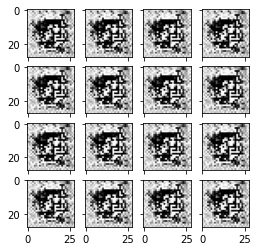

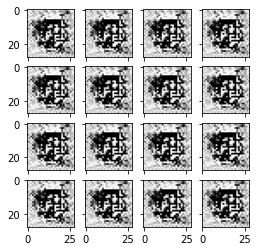

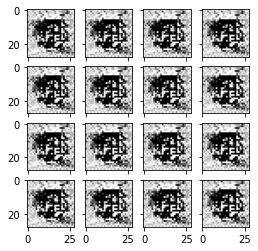

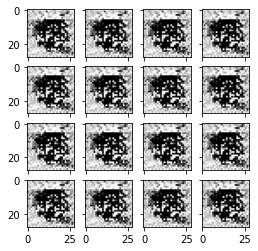

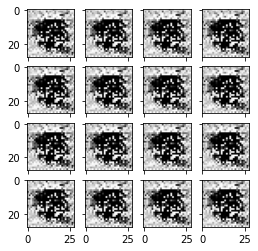

In [7]:
train(5000,128,1000)